# Examples using RBM.py and Autoencoder.py

## RBM.py

The building block for pretraining our autoencoder. RBM.py defines a restricted Boltzmann machine object. In the following section we demonstrate how it works.

In [1]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
import matplotlib.pyplot as plt

from RBM import *

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load training data
df = pd.read_csv("train.csv")
x = df.values[:,1:]
x = x.T
x = (x > 0.35*255).astype(int)  # convert images from greyscale to black and white
np.shape(x)

(784, 42000)

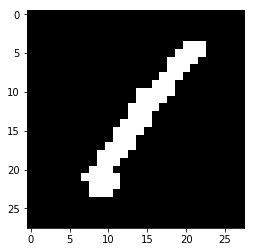

In [3]:
# here is an example of an image
plt.imshow(x[:,0].reshape((28,28)),cmap=plt.cm.gray)
plt.show()

In [4]:
# define a restricted Boltzmann machine
rbm = RBM(v_dim = 784, h_dim = 500)

Epoch 1


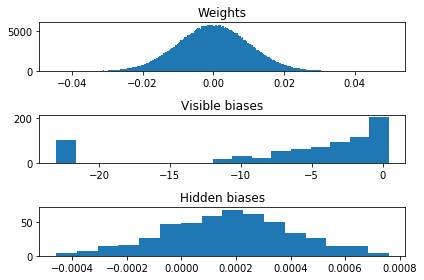

Epoch 2


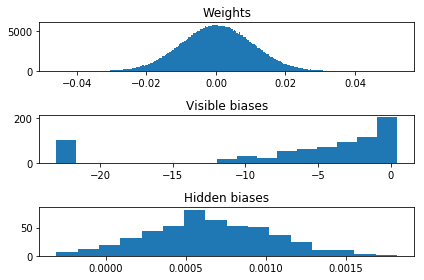

Epoch 3


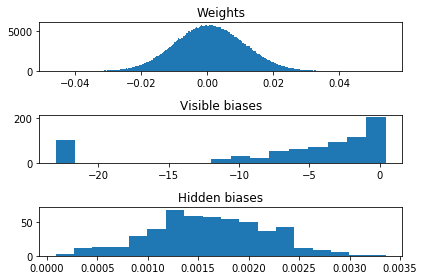

Epoch 4


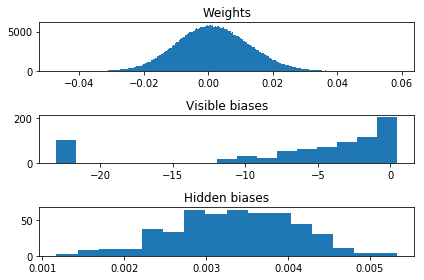

Epoch 5


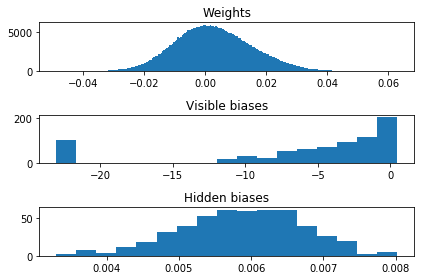

Epoch 6


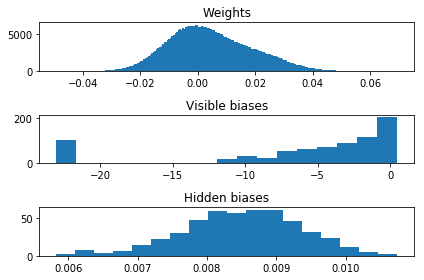

Epoch 7


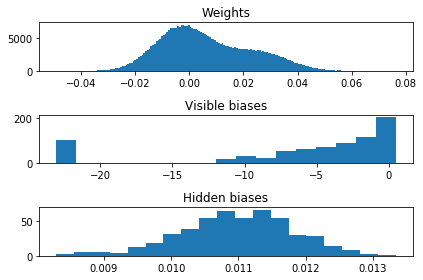

Epoch 8


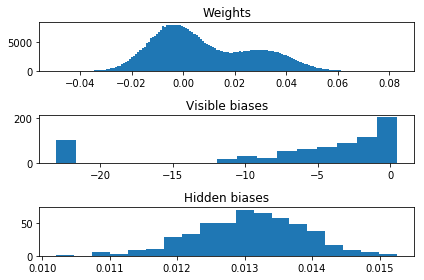

Epoch 9


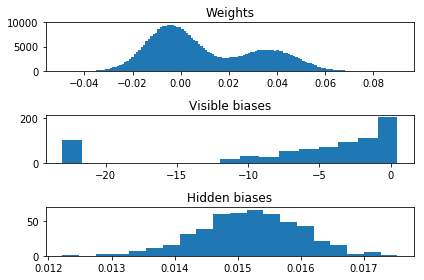

Epoch 10


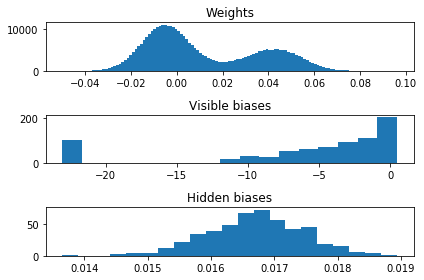

Epoch 11


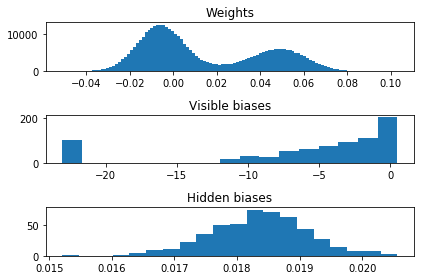

Epoch 12


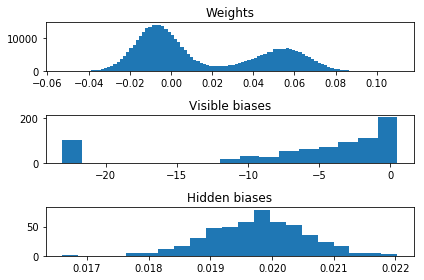

Epoch 13


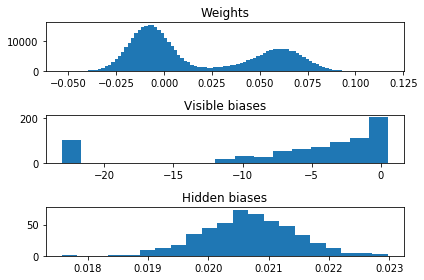

Epoch 14


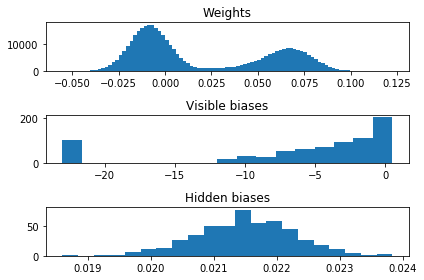

Epoch 15


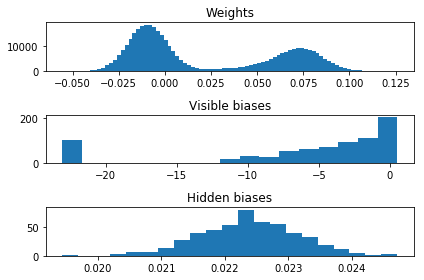

In [6]:
rbm.train(x, epochs = 15, batch_size = 100, learning_rate = .001, plot=True)

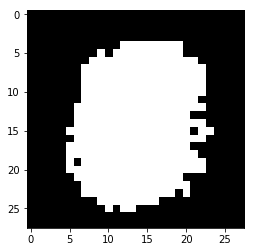

In [7]:
v,_ = rbm.gibbs_sampling(2,1)
plt.imshow(v.reshape((28,28)),cmap=plt.cm.gray)
plt.show()

## Autoencoder.py

In [5]:
from Autoencoder import *

Using TensorFlow backend.


In [8]:
# define an Autoencoder
autoencoder = Autoencoder([784,1000,500,250,30])

Layer dimensions:
Layer 0: 784
Layer 1: 1000
Layer 2: 500
Layer 3: 250
Layer 4: 30


In [ ]:
# pretrain the Autoencoder
autoencoder.pretrain(x, epochs=15, num_samples=40000)

Training layer 1
Epoch 1
Epoch 2
Epoch 3


In [ ]:
# unroll the RBM's into a deep FF autoencoder and summarize the model
autoencoder.unroll()
autoencoder.autoencoder.summary()

In [ ]:
# fine tune the autoencoder with minibatch gradient descent
autoencoder.train(x,epochs=8,learning_rate = 0.001,batch_size = 100)